In [1]:
import os
os.environ['USE_PYGEOS'] = '0'
from pandas import read_csv
import pandas as pd
import geopandas as gps
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import numpy as np
warnings.filterwarnings("ignore")

os.chdir('/Users/xiaodanxu/Documents/SynthFirm.nosync')


plt.style.use('ggplot')
sns.set(font_scale=1.2)  # larger font

# mapping FAF mode to SynthFirm mode
mode_lookup = {1: 'Truck', 2: 'Rail', 3: 'Other', 4: 'Air', 
               5: 'Parcel', 6: 'Other', 7: 'Other', 8: 'Other'}

#define scenario input
analysis_year = [2017, 2040]
# shipment_load_attr = 'tons_' + str(analysis_year)
# shipment_tonmile_attr = 'tmiles_' + str(analysis_year)
# shipment_value_attr = 'value_' + str(analysis_year)

# base_year = 2017
# shipment_load_base = 'tons_' + str(base_year)
# shipment_tonmile_base = 'tmiles_' + str(base_year)
# shipment_value_base = 'value_' + str(base_year)

In [2]:
# load FAF5 data
faf_data = read_csv('validation/FAF5.3.csv', sep = ',')
print(faf_data.columns)

sctg_group_lookup = read_csv('Parameter/SCTG_Groups_revised.csv', sep = ',')
sctg_group_lookup.head(5)

Index(['fr_orig', 'dms_orig', 'dms_dest', 'fr_dest', 'fr_inmode', 'dms_mode',
       'fr_outmode', 'sctg2', 'trade_type', 'dist_band', 'tons_2017',
       'tons_2018', 'tons_2019', 'tons_2020', 'tons_2022', 'tons_2023',
       'tons_2025', 'tons_2030', 'tons_2035', 'tons_2040', 'tons_2045',
       'tons_2050', 'value_2017', 'value_2018', 'value_2019', 'value_2020',
       'value_2022', 'value_2023', 'value_2025', 'value_2030', 'value_2035',
       'value_2040', 'value_2045', 'value_2050', 'current_value_2018',
       'current_value_2019', 'tmiles_2017', 'tmiles_2018', 'tmiles_2019',
       'tmiles_2020', 'tmiles_2022', 'tmiles_2023', 'tmiles_2025',
       'tmiles_2030', 'tmiles_2035', 'tmiles_2040', 'tmiles_2045',
       'tmiles_2050'],
      dtype='object')


,SCTG_Code,SCTG_Group,SCTG_Name,Description
0,1,3,interm_food,Animals and Fish (live)
1,2,1,bulk,Cereal Grains (includes seed)
2,3,3,interm_food,"Agricultural Products (excludes Animal Feed, C..."
3,4,1,interm_food,"Animal Feed, Eggs, Honey, and Other Products o..."
4,5,3,interm_food,"Meat, Poultry, Fish, Seafood, and Their Prepar..."


In [3]:
faf_data.loc[:, 'mode_def'] = faf_data.loc[:, 'dms_mode'].map(mode_lookup)
faf_data = faf_data.loc[faf_data['trade_type'] == 1] #select domestic shipment only
faf_data = \
faf_data.loc[faf_data['mode_def'] != 'Other']
faf_data = pd.merge(faf_data, sctg_group_lookup, 
                    left_on = 'sctg2', right_on = 'SCTG_Code', how = 'left')
faf_data.head(5)

,fr_orig,dms_orig,dms_dest,fr_dest,fr_inmode,dms_mode,fr_outmode,sctg2,trade_type,dist_band,...,tmiles_2030,tmiles_2035,tmiles_2040,tmiles_2045,tmiles_2050,mode_def,SCTG_Code,SCTG_Group,SCTG_Name,Description
0,NaN,11,11,NaN,NaN,1,NaN,1,1,1,...,5.327137,6.342501,7.763605,9.571647,11.343818,Truck,1,3,interm_food,Animals and Fish (live)
1,NaN,11,19,NaN,NaN,1,NaN,1,1,2,...,72.493059,82.113979,96.869428,116.602924,134.683927,Truck,1,3,interm_food,Animals and Fish (live)
2,NaN,11,129,NaN,NaN,1,NaN,1,1,3,...,0.533539,0.564126,0.638719,0.750361,0.844720,Truck,1,3,interm_food,Animals and Fish (live)
3,NaN,11,131,NaN,NaN,1,NaN,1,1,2,...,3.018065,3.155784,3.394250,3.850035,4.178881,Truck,1,3,interm_food,Animals and Fish (live)
4,NaN,11,139,NaN,NaN,1,NaN,1,1,2,...,1.863748,1.969298,2.141527,2.456208,2.683008,Truck,1,3,interm_food,Animals and Fish (live)


In [4]:
# total production and attraction - entire nation
faf_production_out = None
faf_attraction_out = None

for year in analysis_year:
    shipment_load_attr = 'tons_' + str(year)
    shipment_tonmile_attr = 'tmiles_' + str(year)
    shipment_value_attr = 'value_' + str(year)
    aggr_var = [shipment_load_attr, shipment_tonmile_attr, shipment_value_attr]
    faf_production = faf_data.groupby(['dms_orig', 'SCTG_Code', 'SCTG_Name', 'mode_def'])[aggr_var].sum()
    faf_production.columns = ['load', 'tmiles', 'values']
    faf_production = faf_production.reset_index()

    converstion_factor = 10**6/(1000*2000)

    faf_production = faf_production.loc[faf_production['load'] > 0]
    faf_production.loc[:, 'value_density'] = faf_production.loc[:, 'values'] * converstion_factor / \
    faf_production.loc[:, 'load']
    faf_production.loc[:, 'year'] = year
    faf_production_out = pd.concat([faf_production_out, faf_production])
    
    faf_attraction = faf_data.groupby(['dms_dest', 'SCTG_Code', 'SCTG_Name', 'mode_def'])[aggr_var].sum()
    faf_attraction.columns = ['load', 'tmiles', 'values']
    faf_attraction = faf_attraction.reset_index()

    converstion_factor = 10**6/(1000*2000)

    faf_attraction = faf_attraction.loc[faf_attraction['load'] > 0]
    faf_attraction.loc[:, 'value_density'] = faf_attraction.loc[:, 'values'] * converstion_factor / \
    faf_attraction.loc[:, 'load']
    faf_attraction.loc[:, 'year'] = year
    faf_attraction_out = pd.concat([faf_attraction_out, faf_attraction])
    
print(len(faf_production_out))
print(len(faf_production_out.dms_orig.unique()))
faf_production_out.head(5)

24926
132


,dms_orig,SCTG_Code,SCTG_Name,mode_def,load,tmiles,values,value_density,year
0,11,1,interm_food,Truck,640.102013,99.350554,846.596273,0.661298,2017
1,11,2,bulk,Truck,67.017915,9.856307,7.836335,0.058464,2017
2,11,3,interm_food,Parcel,0.006961,0.000408,1.434679,103.051214,2017
3,11,3,interm_food,Truck,460.653998,61.554861,168.547059,0.182943,2017
4,11,4,interm_food,Parcel,0.000458,0.000061,0.000134,0.146288,2017


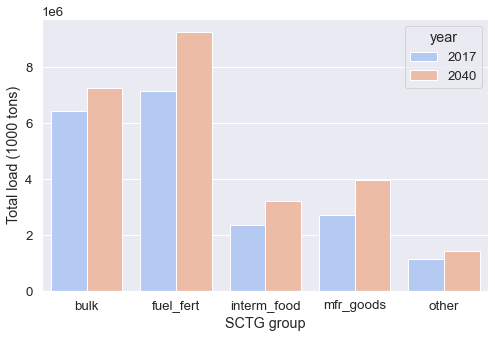

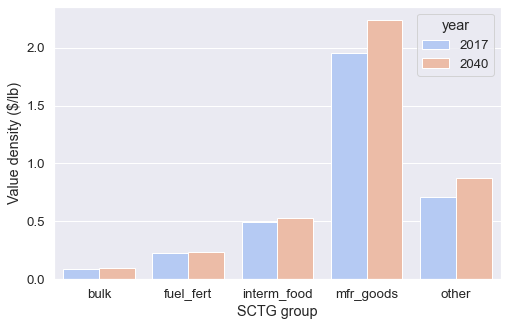

In [5]:
# plot production by SCTG - national
faf_production_tonnage_agg = \
faf_production_out.groupby(['SCTG_Name', 'year'])[['load', 'values']].sum()

faf_production_tonnage_agg = faf_production_tonnage_agg.reset_index()

faf_production_tonnage_agg.loc[:, 'value_density'] = \
faf_production_tonnage_agg.loc[:, 'values'] * converstion_factor / \
faf_production_tonnage_agg.loc[:, 'load']

plt.figure(figsize = (8, 5))
sns.barplot(data = faf_production_tonnage_agg, 
            x = "SCTG_Name", y = "load", hue = "year", palette = 'coolwarm')
plt.xlabel('SCTG group')
plt.ylabel('Total load (1000 tons)')
plt.savefig('plots/forecasted_load_faf.png', dpi = 300, bbox_inches = 'tight')
plt.show()

plt.figure(figsize = (8, 5))
sns.barplot(data = faf_production_tonnage_agg, 
            x = "SCTG_Name", y = "value_density", hue = "year", palette = 'coolwarm')
plt.xlabel('SCTG group')
plt.ylabel('Value density ($/lb)')
plt.savefig('plots/forecasted_value_density_faf_2040only.png', dpi = 300, bbox_inches = 'tight')
plt.show()

In [6]:
faf_production_agg = faf_production_tonnage_agg.groupby(['year'])[['load']].sum()
faf_production_agg = faf_production_agg.reset_index()
faf_production_agg

,year,load
0,2017,1.980884e+07
1,2040,2.510639e+07


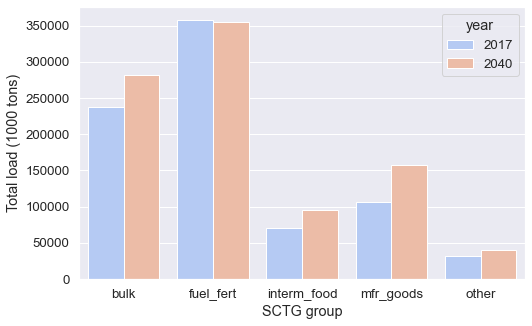

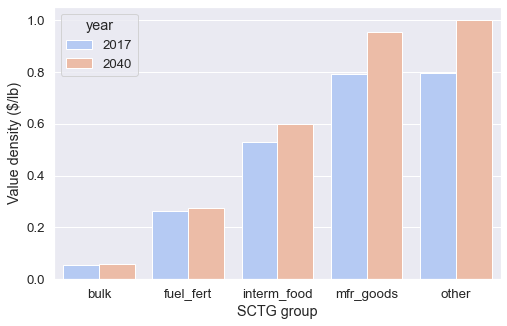

In [5]:
# plot production by SCTG - austin
faf_production_aus = \
faf_production_out.loc[faf_production_out['dms_orig'].isin([481, 488, 489])]
faf_production_tonnage_agg = \
faf_production_aus.groupby(['SCTG_Name', 'year'])[['load', 'values']].sum()

faf_production_tonnage_agg = faf_production_tonnage_agg.reset_index()

faf_production_tonnage_agg.loc[:, 'value_density'] = \
faf_production_tonnage_agg.loc[:, 'values'] * converstion_factor / \
faf_production_tonnage_agg.loc[:, 'load']

plt.figure(figsize = (8, 5))
sns.barplot(data = faf_production_tonnage_agg, 
            x = "SCTG_Name", y = "load", hue = "year", palette = 'coolwarm')
plt.xlabel('SCTG group')
plt.ylabel('Total load (1000 tons)')
plt.savefig('plots/forecasted_load_faf_aus_2040only.png', dpi = 300, bbox_inches = 'tight')
plt.show()

plt.figure(figsize = (8, 5))
sns.barplot(data = faf_production_tonnage_agg, 
            x = "SCTG_Name", y = "value_density", hue = "year", palette = 'coolwarm')
plt.xlabel('SCTG group')
plt.ylabel('Value density ($/lb)')
plt.savefig('plots/forecasted_value_density_faf_aus_2040only.png', dpi = 300, bbox_inches = 'tight')
plt.show()

In [13]:
faf_production_aus_agg = faf_production_aus.groupby(['year'])[['load']].sum()
faf_production_aus_agg = faf_production_aus_agg.reset_index()
faf_production_aus_agg

,year,load
0,2017,804709.339949
1,2040,929992.787167


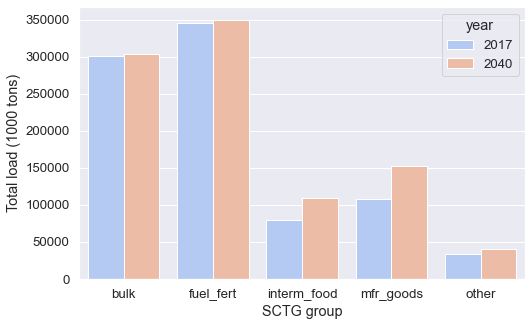

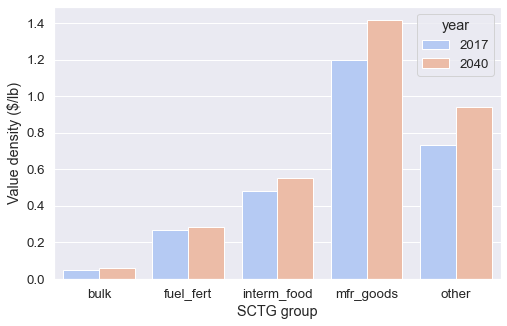

In [6]:
# plot consumption by SCTG - austin
faf_attraction_aus = \
faf_attraction_out.loc[faf_attraction_out['dms_dest'].isin([481, 488, 489])]
faf_attraction_tonnage_agg = \
faf_attraction_aus.groupby(['SCTG_Name', 'year'])[['load', 'values']].sum()

faf_attraction_tonnage_agg = faf_attraction_tonnage_agg.reset_index()

faf_attraction_tonnage_agg.loc[:, 'value_density'] = \
faf_attraction_tonnage_agg.loc[:, 'values'] * converstion_factor / \
faf_attraction_tonnage_agg.loc[:, 'load']

plt.figure(figsize = (8, 5))
sns.barplot(data = faf_attraction_tonnage_agg, 
            x = "SCTG_Name", y = "load", hue = "year", palette = 'coolwarm')
plt.xlabel('SCTG group')
plt.ylabel('Total load (1000 tons)')
plt.savefig('plots/forecasted_attr_load_faf_aus_2040only.png', dpi = 300, bbox_inches = 'tight')
plt.show()

plt.figure(figsize = (8, 5))
sns.barplot(data = faf_attraction_tonnage_agg, 
            x = "SCTG_Name", y = "value_density", hue = "year", palette = 'coolwarm')
plt.xlabel('SCTG group')
plt.ylabel('Value density ($/lb)')
plt.savefig('plots/forecasted_attr_value_density_faf_aus_2040only.png', dpi = 300, bbox_inches = 'tight')
plt.show()

In [8]:
faf_attraction_aus_agg = faf_attraction_aus.groupby('year')[['load']].sum()
faf_attraction_aus_agg = faf_attraction_aus_agg.reset_index()
faf_attraction_aus_agg

,year,load
0,2017,868085.339193
1,2040,954469.969187


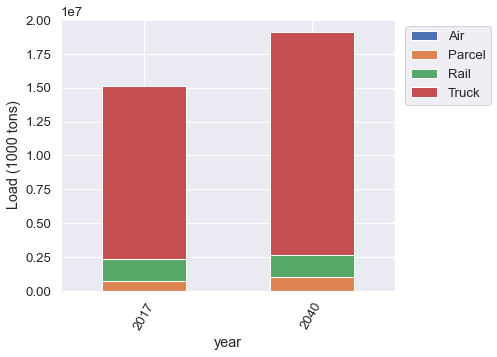

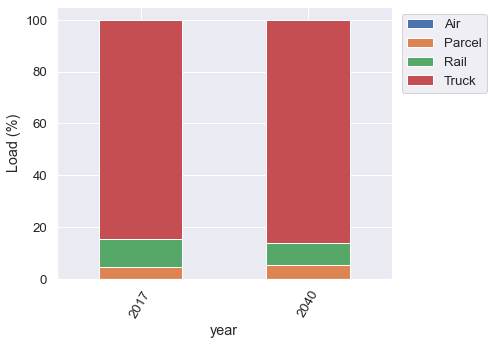

In [10]:
# plot production by mode - national
faf_production_by_mode = \
pd.pivot_table(faf_production_out, values='load', index=['year'],
                       columns=['mode_def'], aggfunc=np.sum, fill_value=0)
# faf_production_by_mode = faf_production_by_mode.reset_index()
faf_production_by_mode = faf_production_by_mode.drop(columns = 'Other')
faf_production_by_mode.head(5)
faf_production_by_mode.plot.bar(stacked=True, figsize = (6,5))
plt.legend(bbox_to_anchor = (1.01, 1))
plt.xticks(rotation = 60)
plt.ylabel('Load (1000 tons)')
plt.savefig('plots/forecasted_load_by_mode_faf_2040only.png', dpi = 300, bbox_inches = 'tight')
plt.show()
faf_production_by_mode.loc[:, 'sum'] = faf_production_by_mode.sum(axis = 1)
faf_production_by_mode.loc[:, 'Truck'] = 100 * faf_production_by_mode.loc[:, 'Truck']/ faf_production_by_mode.loc[:, 'sum']
faf_production_by_mode.loc[:, 'Air'] = 100 * faf_production_by_mode.loc[:, 'Air']/ faf_production_by_mode.loc[:, 'sum']
faf_production_by_mode.loc[:, 'Parcel'] = 100 * faf_production_by_mode.loc[:, 'Parcel']/ faf_production_by_mode.loc[:, 'sum']
faf_production_by_mode.loc[:, 'Rail'] = 100 * faf_production_by_mode.loc[:, 'Rail']/ faf_production_by_mode.loc[:, 'sum']
faf_production_by_mode = faf_production_by_mode.drop(columns = 'sum')
faf_production_by_mode.head(5)
faf_production_by_mode.plot.bar(stacked=True, figsize = (6,5))
plt.legend(bbox_to_anchor = (1.01, 1))
plt.xticks(rotation = 60)
plt.ylabel('Load (%)')
plt.savefig('plots/forecasted_load_by_mode_faf_percent_2040only.png', dpi = 300, bbox_inches = 'tight')
plt.show()

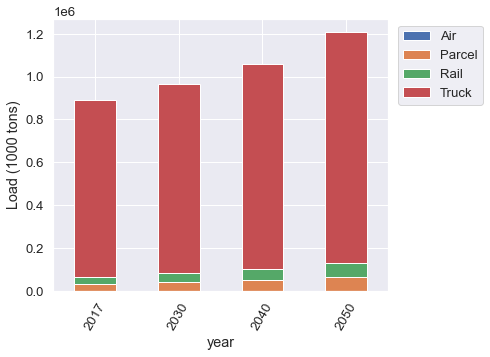

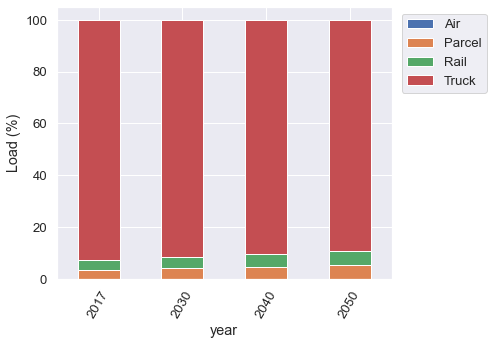

In [12]:
# plot production by mode - austin
faf_production_by_mode = \
pd.pivot_table(faf_production_aus, values='load', index=['year'],
                       columns=['mode_def'], aggfunc=np.sum, fill_value=0)
# faf_production_by_mode = faf_production_by_mode.reset_index()
faf_production_by_mode = faf_production_by_mode.drop(columns = 'Other')
faf_production_by_mode.head(5)
faf_production_by_mode.plot.bar(stacked=True, figsize = (6,5))
plt.legend(bbox_to_anchor = (1.01, 1))
plt.xticks(rotation = 60)
plt.ylabel('Load (1000 tons)')
plt.savefig('plots/forecasted_load_by_mode_faf_aus.png', dpi = 300, bbox_inches = 'tight')
plt.show()

faf_production_by_mode_frac = faf_production_by_mode.copy()
faf_production_by_mode_frac.loc[:, 'sum'] = faf_production_by_mode_frac.sum(axis = 1)
faf_production_by_mode_frac.loc[:, 'Truck'] = 100 * faf_production_by_mode_frac.loc[:, 'Truck']/ faf_production_by_mode_frac.loc[:, 'sum']
faf_production_by_mode_frac.loc[:, 'Air'] = 100 * faf_production_by_mode_frac.loc[:, 'Air']/ faf_production_by_mode_frac.loc[:, 'sum']
faf_production_by_mode_frac.loc[:, 'Parcel'] = 100 * faf_production_by_mode_frac.loc[:, 'Parcel']/ faf_production_by_mode_frac.loc[:, 'sum']
faf_production_by_mode_frac.loc[:, 'Rail'] = 100 * faf_production_by_mode_frac.loc[:, 'Rail']/ faf_production_by_mode_frac.loc[:, 'sum']
faf_production_by_mode_frac = faf_production_by_mode_frac.drop(columns = 'sum')
faf_production_by_mode_frac.head(5)
faf_production_by_mode_frac.plot.bar(stacked=True, figsize = (6,5))
plt.legend(bbox_to_anchor = (1.01, 1))
plt.xticks(rotation = 60)
plt.ylabel('Load (%)')
plt.savefig('plots/forecasted_load_by_mode_faf_percent_aus.png', dpi = 300, bbox_inches = 'tight')
plt.show()

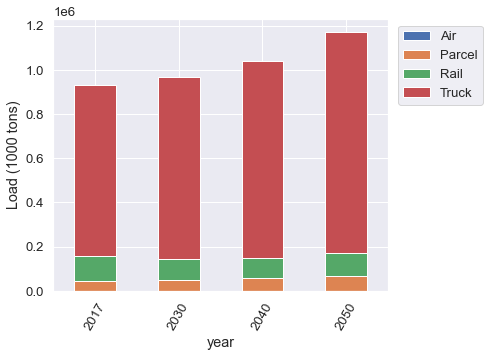

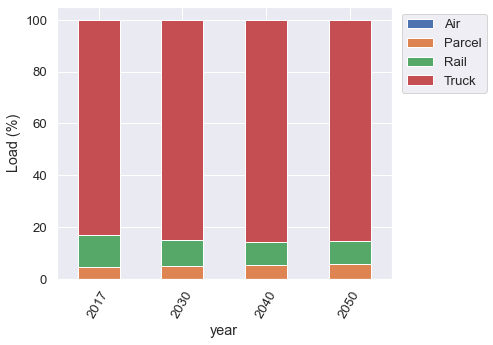

In [13]:
# plot attraction by mode - austin
faf_attraction_by_mode = \
pd.pivot_table(faf_attraction_aus, values='load', index=['year'],
                       columns=['mode_def'], aggfunc=np.sum, fill_value=0)
# faf_production_by_mode = faf_production_by_mode.reset_index()
faf_attraction_by_mode = faf_attraction_by_mode.drop(columns = 'Other')
faf_attraction_by_mode.head(5)
faf_attraction_by_mode.plot.bar(stacked=True, figsize = (6,5))
plt.legend(bbox_to_anchor = (1.01, 1))
plt.xticks(rotation = 60)
plt.ylabel('Load (1000 tons)')
plt.savefig('plots/forecasted_attr_load_by_mode_faf_aus.png', dpi = 300, bbox_inches = 'tight')
plt.show()

faf_attraction_by_mode_frac = faf_attraction_by_mode.copy()
faf_attraction_by_mode_frac.loc[:, 'sum'] = faf_attraction_by_mode_frac.sum(axis = 1)
faf_attraction_by_mode_frac.loc[:, 'Truck'] = 100 * faf_attraction_by_mode_frac.loc[:, 'Truck']/ faf_attraction_by_mode_frac.loc[:, 'sum']
faf_attraction_by_mode_frac.loc[:, 'Air'] = 100 * faf_attraction_by_mode_frac.loc[:, 'Air']/ faf_attraction_by_mode_frac.loc[:, 'sum']
faf_attraction_by_mode_frac.loc[:, 'Parcel'] = 100 * faf_attraction_by_mode_frac.loc[:, 'Parcel']/ faf_attraction_by_mode_frac.loc[:, 'sum']
faf_attraction_by_mode_frac.loc[:, 'Rail'] = 100 * faf_attraction_by_mode_frac.loc[:, 'Rail']/ faf_attraction_by_mode_frac.loc[:, 'sum']
faf_attraction_by_mode_frac = faf_attraction_by_mode_frac.drop(columns = 'sum')
faf_attraction_by_mode_frac.head(5)
faf_attraction_by_mode_frac.plot.bar(stacked=True, figsize = (6,5))
plt.legend(bbox_to_anchor = (1.01, 1))
plt.xticks(rotation = 60)
plt.ylabel('Load (%)')
plt.savefig('plots/forecasted_attr_load_by_mode_faf_percent_aus.png', dpi = 300, bbox_inches = 'tight')
plt.show()

In [15]:
faf_production_by_mode.loc[:, 'sum'] = faf_production_by_mode.sum(axis = 1)
faf_production_by_mode = faf_production_by_mode.reset_index()
faf_production_by_mode.loc[:, 'direction'] = 'Outbound'

faf_attraction_by_mode.loc[:, 'sum'] = faf_attraction_by_mode.sum(axis = 1)
faf_attraction_by_mode = faf_attraction_by_mode.reset_index()
faf_attraction_by_mode.loc[:, 'direction'] = 'Inbound'

faf_results_by_mode_aus = \
pd.concat([faf_production_by_mode, faf_attraction_by_mode])

faf_results_by_mode_aus.to_csv('Validation/FAF_tonnage_by_mode_aus.csv', index = False)
faf_results_by_mode_aus.head(5)

mode_def,year,Air,Parcel,Rail,Truck,sum,direction
0,2017,71.798166,29923.483452,35094.199150,8.240528e+05,8.891423e+05,Outbound
1,2030,90.352015,38900.948375,42192.517003,8.852403e+05,9.664241e+05,Outbound
2,2040,114.998278,49181.703342,52261.391610,9.593600e+05,1.060918e+06,Outbound
3,2050,148.931681,63087.214883,65885.451080,1.079969e+06,1.209091e+06,Outbound
0,2017,101.634390,42022.105542,116695.867845,7.732421e+05,9.320617e+05,Inbound


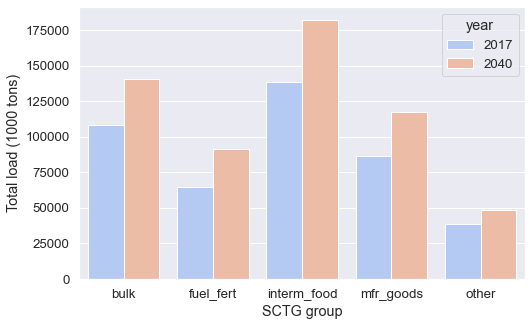

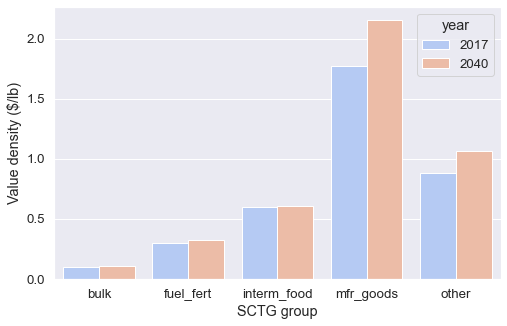

In [9]:
# plot production by SCTG - sf bay
faf_production_bay = \
faf_production_out.loc[faf_production_out['dms_orig'].isin([62, 64, 65, 69])]
faf_production_tonnage_agg = \
faf_production_bay.groupby(['SCTG_Name', 'year'])[['load', 'values']].sum()

faf_production_tonnage_agg = faf_production_tonnage_agg.reset_index()

faf_production_tonnage_agg.loc[:, 'value_density'] = \
faf_production_tonnage_agg.loc[:, 'values'] * converstion_factor / \
faf_production_tonnage_agg.loc[:, 'load']

plt.figure(figsize = (8, 5))
sns.barplot(data = faf_production_tonnage_agg, 
            x = "SCTG_Name", y = "load", hue = "year", palette = 'coolwarm')
plt.xlabel('SCTG group')
plt.ylabel('Total load (1000 tons)')
plt.savefig('plots_SF/forecasted_load_faf_SF_2040only.png', dpi = 300, bbox_inches = 'tight')
plt.show()

plt.figure(figsize = (8, 5))
sns.barplot(data = faf_production_tonnage_agg, 
            x = "SCTG_Name", y = "value_density", hue = "year", palette = 'coolwarm')
plt.xlabel('SCTG group')
plt.ylabel('Value density ($/lb)')
plt.savefig('plots_SF/forecasted_value_density_faf_SF_2040only.png', dpi = 300, bbox_inches = 'tight')
plt.show()

In [10]:
faf_production_bay_agg = faf_production_bay.groupby('year')[['load']].sum()
faf_production_bay_agg = faf_production_bay_agg.reset_index()
faf_production_bay_agg

,year,load
0,2017,436073.971776
1,2040,579587.604570


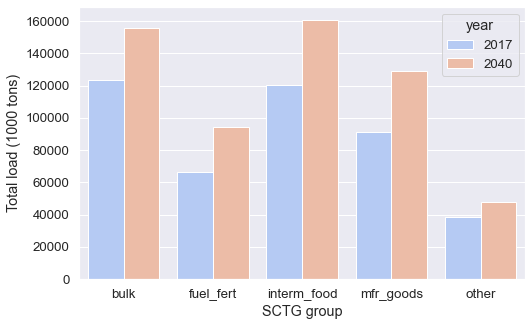

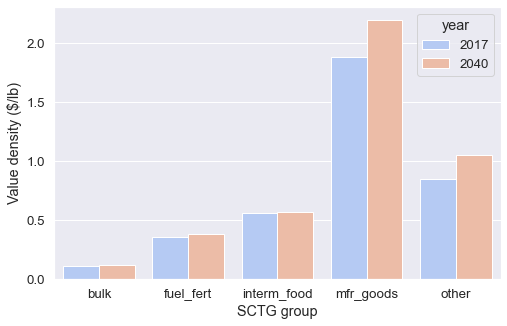

In [11]:
# plot consumption by SCTG - SF
faf_attraction_sf = \
faf_attraction_out.loc[faf_attraction_out['dms_dest'].isin([62, 64, 65, 69])]
faf_attraction_tonnage_agg = \
faf_attraction_sf.groupby(['SCTG_Name', 'year'])[['load', 'values']].sum()

faf_attraction_tonnage_agg = faf_attraction_tonnage_agg.reset_index()

faf_attraction_tonnage_agg.loc[:, 'value_density'] = \
faf_attraction_tonnage_agg.loc[:, 'values'] * converstion_factor / \
faf_attraction_tonnage_agg.loc[:, 'load']

plt.figure(figsize = (8, 5))
sns.barplot(data = faf_attraction_tonnage_agg, 
            x = "SCTG_Name", y = "load", hue = "year", palette = 'coolwarm')
plt.xlabel('SCTG group')
plt.ylabel('Total load (1000 tons)')
plt.savefig('plots_SF/forecasted_attr_load_faf_SF_2040only.png', dpi = 300, bbox_inches = 'tight')
plt.show()

plt.figure(figsize = (8, 5))
sns.barplot(data = faf_attraction_tonnage_agg, 
            x = "SCTG_Name", y = "value_density", hue = "year", palette = 'coolwarm')
plt.xlabel('SCTG group')
plt.ylabel('Value density ($/lb)')
plt.savefig('plots_SF/forecasted_attr_value_density_faf_SF_2040only.png', dpi = 300, bbox_inches = 'tight')
plt.show()

In [12]:
faf_attraction_sf_agg = faf_attraction_sf.groupby('year')[['load']].sum()
faf_attraction_sf_agg = faf_attraction_sf_agg.reset_index()
faf_attraction_sf_agg

,year,load
0,2017,440263.107518
1,2040,587644.600188


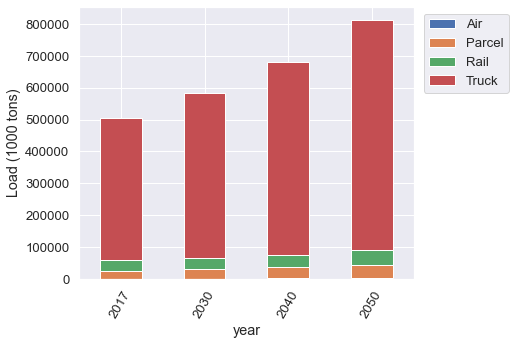

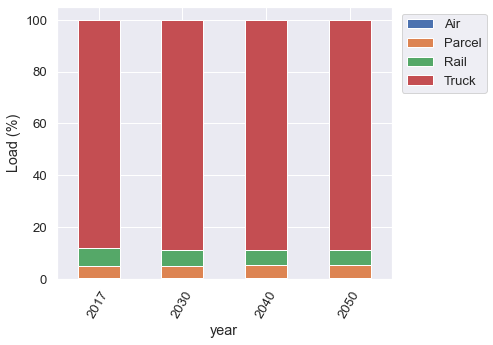

In [9]:
# plot production by mode - SF
faf_production_by_mode = \
pd.pivot_table(faf_attraction_sf, values='load', index=['year'],
                       columns=['mode_def'], aggfunc=np.sum, fill_value=0)
# faf_production_by_mode = faf_production_by_mode.reset_index()
faf_production_by_mode = faf_production_by_mode.drop(columns = 'Other')
faf_production_by_mode.head(5)
faf_production_by_mode.plot.bar(stacked=True, figsize = (6,5))
plt.legend(bbox_to_anchor = (1.01, 1))
plt.xticks(rotation = 60)
plt.ylabel('Load (1000 tons)')
plt.savefig('plots_SF/forecasted_load_by_mode_faf_SF.png', dpi = 300, bbox_inches = 'tight')
plt.show()

faf_production_by_mode_frac = faf_production_by_mode.copy()
faf_production_by_mode_frac.loc[:, 'sum'] = faf_production_by_mode_frac.sum(axis = 1)
faf_production_by_mode_frac.loc[:, 'Truck'] = 100 * faf_production_by_mode_frac.loc[:, 'Truck']/ faf_production_by_mode_frac.loc[:, 'sum']
faf_production_by_mode_frac.loc[:, 'Air'] = 100 * faf_production_by_mode_frac.loc[:, 'Air']/ faf_production_by_mode_frac.loc[:, 'sum']
faf_production_by_mode_frac.loc[:, 'Parcel'] = 100 * faf_production_by_mode_frac.loc[:, 'Parcel']/ faf_production_by_mode_frac.loc[:, 'sum']
faf_production_by_mode_frac.loc[:, 'Rail'] = 100 * faf_production_by_mode_frac.loc[:, 'Rail']/ faf_production_by_mode_frac.loc[:, 'sum']
faf_production_by_mode_frac = faf_production_by_mode_frac.drop(columns = 'sum')
faf_production_by_mode_frac.head(5)
faf_production_by_mode_frac.plot.bar(stacked=True, figsize = (6,5))
plt.legend(bbox_to_anchor = (1.01, 1))
plt.xticks(rotation = 60)
plt.ylabel('Load (%)')
plt.savefig('plots_SF/forecasted_load_by_mode_faf_percent_SF.png', dpi = 300, bbox_inches = 'tight')
plt.show()

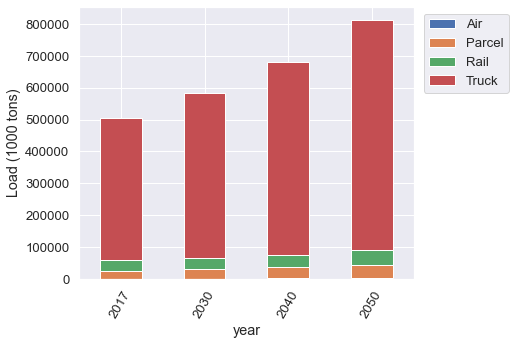

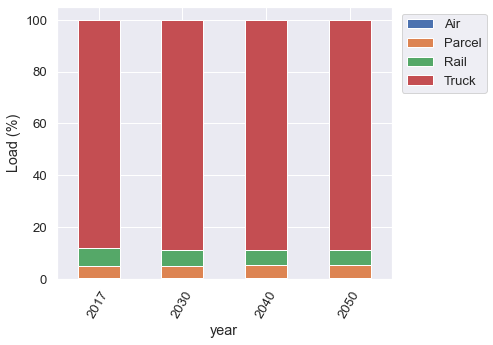

In [10]:
# plot attraction by mode - SF
faf_attraction_by_mode = \
pd.pivot_table(faf_attraction_sf, values='load', index=['year'],
                       columns=['mode_def'], aggfunc=np.sum, fill_value=0)
# faf_production_by_mode = faf_production_by_mode.reset_index()
faf_attraction_by_mode = faf_attraction_by_mode.drop(columns = 'Other')
faf_attraction_by_mode.head(5)
faf_attraction_by_mode.plot.bar(stacked=True, figsize = (6,5))
plt.legend(bbox_to_anchor = (1.01, 1))
plt.xticks(rotation = 60)
plt.ylabel('Load (1000 tons)')
plt.savefig('plots_SF/forecasted_attr_load_by_mode_faf_SF.png', dpi = 300, bbox_inches = 'tight')
plt.show()

faf_attraction_by_mode_frac = faf_attraction_by_mode.copy()
faf_attraction_by_mode_frac.loc[:, 'sum'] = faf_attraction_by_mode_frac.sum(axis = 1)
faf_attraction_by_mode_frac.loc[:, 'Truck'] = 100 * faf_attraction_by_mode_frac.loc[:, 'Truck']/ faf_attraction_by_mode_frac.loc[:, 'sum']
faf_attraction_by_mode_frac.loc[:, 'Air'] = 100 * faf_attraction_by_mode_frac.loc[:, 'Air']/ faf_attraction_by_mode_frac.loc[:, 'sum']
faf_attraction_by_mode_frac.loc[:, 'Parcel'] = 100 * faf_attraction_by_mode_frac.loc[:, 'Parcel']/ faf_attraction_by_mode_frac.loc[:, 'sum']
faf_attraction_by_mode_frac.loc[:, 'Rail'] = 100 * faf_attraction_by_mode_frac.loc[:, 'Rail']/ faf_attraction_by_mode_frac.loc[:, 'sum']
faf_attraction_by_mode_frac = faf_attraction_by_mode_frac.drop(columns = 'sum')
faf_attraction_by_mode_frac.head(5)
faf_attraction_by_mode_frac.plot.bar(stacked=True, figsize = (6,5))
plt.legend(bbox_to_anchor = (1.01, 1))
plt.xticks(rotation = 60)
plt.ylabel('Load (%)')
plt.savefig('plots_SF/forecasted_attr_load_by_mode_faf_percent_SF.png', dpi = 300, bbox_inches = 'tight')
plt.show()

In [11]:
faf_production_by_mode.loc[:, 'sum'] = faf_production_by_mode.sum(axis = 1)
faf_production_by_mode = faf_production_by_mode.reset_index()
faf_production_by_mode.loc[:, 'direction'] = 'Outbound'

faf_attraction_by_mode.loc[:, 'sum'] = faf_attraction_by_mode.sum(axis = 1)
faf_attraction_by_mode = faf_attraction_by_mode.reset_index()
faf_attraction_by_mode.loc[:, 'direction'] = 'Inbound'

faf_results_by_mode_aus = \
pd.concat([faf_production_by_mode, faf_attraction_by_mode])

faf_results_by_mode_aus.to_csv('Validation/FAF_tonnage_by_mode_SF.csv', index = False)
faf_results_by_mode_aus.head(5)

mode_def,year,Air,Parcel,Rail,Truck,sum,direction
0,2017,535.635336,24138.321340,34591.081992,444757.691319,504022.729987,Outbound
1,2030,666.835164,28477.012773,35758.295566,519758.361942,584660.505445,Outbound
2,2040,853.560620,34689.107481,39779.289558,606112.899879,681434.857538,Outbound
3,2050,1101.992846,43123.486773,45657.093614,723184.038139,813066.611372,Outbound
0,2017,535.635336,24138.321340,34591.081992,444757.691319,504022.729987,Inbound
